# Creating an interannual monthly Chl that I can save and be able to more easily use in my other figures

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import dask
#import esmlab
import utils
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from scipy import stats

In [2]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [3]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

## Seasonality and interannual variability in SPECTRA

In [4]:
case = 'g.e21.G1850ECOIAF.t62_g17.marbl0_33.GNG595'
path = f'/glade/campaign/cesm/development/bgcwg/projects/marbl-spectra/{case}/ocn/hist'

In [5]:
variables = [f'{var}' for var in ['diat1Chl','diat2Chl','diat3Chl', 'ppChl', 'diazChl', 'mp1Chl','mp2Chl','mp3Chl','mp4Chl']]
coords = {'x':'TLONG','y':'TLAT'}
keep_vars = variables + list(coords.values())+['dz','KMT','time']

In [6]:
%%time

ds_avg = xr.Dataset()

for year in np.arange(63,125,1):
    yr4="0{:02d}".format(year).zfill(4)
    print(year)
    
    ds_annual = xr.Dataset()

    file = sorted(glob(f'{path}/{case}.pop.h.{yr4}-*.nc'))
    
    dsv_annual=xr.open_mfdataset(file, decode_times=True,drop_variables=["transport_components", "transport_regions"], 
                            parallel=True, compat="override", combine='nested', concat_dim="time",data_vars="minimal",coords='minimal' )
    
    for vv in variables: 
        ds_annual = xr.merge((ds_annual, dsv_annual[vv]))
        

    ds_annual = ds_annual.drop([v for v in ds_annual.variables if v not in keep_vars]).squeeze()
    ds_avg = xr.concat([ds_avg, ds_annual],dim='year',data_vars="different",join="override")

63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
CPU times: user 7min 25s, sys: 1min 50s, total: 9min 15s
Wall time: 11min 47s


In [7]:
ds_avg.ppChl

<xarray.DataArray 'ppChl' (year: 62, time: 12, z_t_150m: 15, nlat: 384,
                           nlon: 320)>
dask.array<concatenate, shape=(62, 12, 15, 384, 320), dtype=float32, chunksize=(2, 1, 15, 305, 305), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0063-02-01 00:00:00 ... 0064-01-01 00:00:00
    TLONG    (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
Dimensions without coordinates: year, z_t_150m, nlat, nlon
Attributes:
    long_name:     Picoplankton Chlorophyll
    units:         mg/m^3
    grid_loc:      3114
    cell_methods:  time: mean

In [10]:
%%time
# Phytoplankton biomass
phyto_names = ['pp','diaz','mp1','diat1','mp2','diat2','mp3','diat3','mp4']
phyto_vars = [''+v+'Chl' for v in phyto_names]
pbmss = xr.concat([ds_avg[v] for v in phyto_vars], dim='var') # units are mg/m^3

CPU times: user 142 ms, sys: 2.72 ms, total: 145 ms
Wall time: 151 ms


In [11]:
pbmss

<xarray.DataArray 'ppChl' (var: 9, year: 62, time: 12, z_t_150m: 15, nlat: 384,
                           nlon: 320)>
dask.array<concatenate, shape=(9, 62, 12, 15, 384, 320), dtype=float32, chunksize=(1, 2, 1, 15, 305, 305), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0063-02-01 00:00:00 ... 0064-01-01 00:00:00
    TLONG    (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
Dimensions without coordinates: var, year, z_t_150m, nlat, nlon
Attributes:
    long_name:     Picoplankton Chlorophyll
    units:         mg/m^3
    grid_loc:      3114
    cell_methods:  time: mean

In [12]:
surface_chl =pbmss[:,:,:,0,:,:] # units should be $mg Chl$ $m^{-3}$

In [13]:
surface_chl.shape

(9, 62, 12, 384, 320)

In [14]:
### 20 year climatology GNG513b from 43 to 62 representing Jan 1990 - Dec 2009.
path = '/glade/campaign/cesm/development/bgcwg/projects/marbl-spectra/GNG595_2ndcycle_1990-2009_clim'
files = sorted(glob(f'{path}/*.nc', recursive=True),key=numericalSort)
ds= xr.open_mfdataset(files,combine='by_coords')

In [15]:
year = np.arange(1948,2010)
year

array([1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958,
       1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969,
       1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
       1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009])

In [16]:
%%time
month = np.arange(0,12)
year = np.arange(1948,2010)
names = np.arange(0,9) # Remember that the this is the list: ['pp','diaz','mp1','diat1','mp2','diat2','mp3','diat3','mp4']
ds_bmss = xr.DataArray(data=surface_chl[0,:,:,:,:], coords={'time':year,'month':month,'nlat':ds_avg.nlat, 'nlon':ds.nlon}, 
                           dims=['time','month','nlat','nlon'])
ds_bmss = ds_bmss.to_dataset(name='ppChl')
ds_bmss['diazChl'] = xr.DataArray(data=surface_chl[1,:,:,:,:], coords={'time':year,'month':month,'nlat':ds.nlat, 'nlon':ds.nlon}, 
                           dims=['time','month','nlat','nlon'])
ds_bmss['mp1Chl'] = xr.DataArray(data=surface_chl[2,:,:,:,:], coords={'time':year,'month':month,'nlat':ds.nlat, 'nlon':ds.nlon}, 
                           dims=['time','month','nlat','nlon'])
ds_bmss['diat1Chl'] = xr.DataArray(data=surface_chl[3,:,:,:,:], coords={'time':year,'month':month,'nlat':ds.nlat, 'nlon':ds.nlon}, 
                           dims=['time','month','nlat','nlon'])
ds_bmss['mp2Chl'] = xr.DataArray(data=surface_chl[4,:,:,:,:], coords={'time':year,'month':month,'nlat':ds.nlat, 'nlon':ds.nlon}, 
                           dims=['time','month','nlat','nlon'])
ds_bmss['diat2Chl'] = xr.DataArray(data=surface_chl[5,:,:,:,:], coords={'time':year,'month':month,'nlat':ds.nlat, 'nlon':ds.nlon}, 
                           dims=['time','month','nlat','nlon'])
ds_bmss['mp3Chl'] = xr.DataArray(data=surface_chl[6,:,:,:,:], coords={'time':year,'month':month,'nlat':ds.nlat, 'nlon':ds.nlon}, 
                           dims=['time','month','nlat','nlon'])
ds_bmss['diat3Chl'] = xr.DataArray(data=surface_chl[7,:,:,:,:], coords={'time':year,'month':month,'nlat':ds.nlat, 'nlon':ds.nlon}, 
                           dims=['time','month','nlat','nlon'])
ds_bmss['mp4Chl'] = xr.DataArray(data=surface_chl[8,:,:,:,:], coords={'time':year,'month':month,'nlat':ds.nlat, 'nlon':ds.nlon}, 
                           dims=['time','month','nlat','nlon'])
ds_bmss['TLONG']=xr.DataArray(data=ds.TLONG, coords={'nlat':ds.nlat, 'nlon':ds.nlon}, 
                           dims=['nlat','nlon'])
ds_bmss['TLAT']=xr.DataArray(data=ds.TLAT, coords={'nlat':ds.nlat, 'nlon':ds.nlon}, 
                           dims=['nlat','nlon'])

CPU times: user 129 ms, sys: 0 ns, total: 129 ms
Wall time: 135 ms


In [18]:
%%time
new_filename_1 = '/glade/derecho/scratch/gabyn/SPECTRA_hindcast/SPECTRA_1990_2009/GNG595_monthly_yearly_1948_2009/chl_ch2_1948_2009.nc'
ds_bmss.to_netcdf(path=new_filename_1)

CPU times: user 2min 24s, sys: 12min 44s, total: 15min 9s
Wall time: 43min 54s


In [30]:
ds_bmss

<xarray.Dataset>
Dimensions:        (time: 62, month: 12, nlat: 384, nlon: 320)
Coordinates:
  * time           (time) int64 1948 1949 1950 1951 1952 ... 2006 2007 2008 2009
  * month          (month) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * nlat           (nlat) int64 0 1 2 3 4 5 6 7 ... 377 378 379 380 381 382 383
  * nlon           (nlon) int64 0 1 2 3 4 5 6 7 ... 313 314 315 316 317 318 319
Data variables:
    ppC_150m_zint  (time, month, nlat, nlon) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    diazC          (time, month, nlat, nlon) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    mp1C           (time, month, nlat, nlon) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    diat1C         (time, month, nlat, nlon) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    mp2C           (time, month, nlat, nlon) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    diat2C         (time, month, nlat, nlon) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    mp3C           (time, month, nlat, nlon) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    diat3C         (time, month, nlat, nlon) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    mp4C           (time, month, nlat, nlon) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    photoC_TOT     (time, month, nlat, nlon) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    TLONG          (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT           (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>

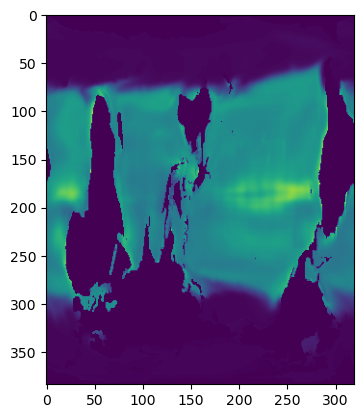

In [32]:
plt.imshow(np.nanmean(ds_bmss.ppC_150m_zint,axis=(0,1)))

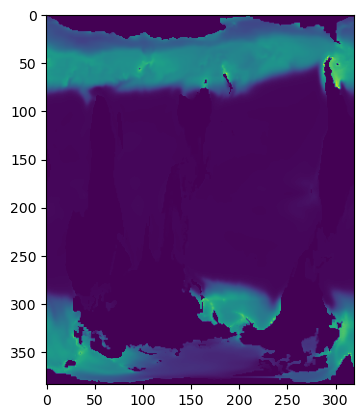

In [33]:
plt.imshow(np.nanmean(ds_bmss.mp1Chl,axis=(0,1)))

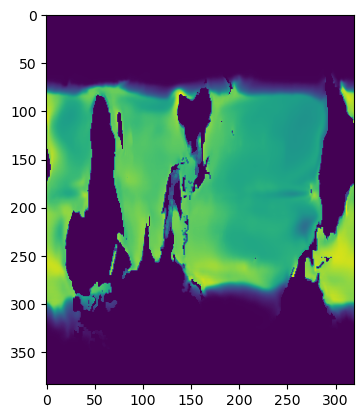

In [34]:
plt.imshow(np.nanmean(ds_bmss.diazChl,axis=(0,1)))

# Regrid to 180 by 360 grid

## 3. Regrid from that nc file (you can do this in bash)
module load nco
module load cdo

cd /glade/derecho/scratch/gabyn/SPECTRA_hindcast/SPECTRA_1990_2009/GNG595_monthly_yearly_1948_2009/
# ppC 
ncatted -a coordinates,ppC_150m_zint,c,c,"TLONG TLAT" chl_ch2_1948_2009.nc
cdo remapbil,r360x180 -selname,ppC_150m_zint chl_ch2_1948_2009.nc chl_ch2_1948_2009_ppChl.nc
cdo sellonlatbox,-180,180,-89.5,89.5 chl_ch2_1948_2009_ppChl.nc regrid_chl_ch2_1948_2009_ppChl.nc

# diatC 
ncatted -a coordinates,diat1Chl,c,c,"TLONG TLAT" chl_ch2_1948_2009.nc
cdo remapbil,r360x180 -selname,diat1Chl chl_ch2_1948_2009.nc chl_ch2_1948_2009_diat1Chl.nc
cdo sellonlatbox,-180,180,-89.5,89.5 chl_ch2_1948_2009_diat1Chl.nc regrid_chl_ch2_1948_2009_diat1Chl.nc

ncatted -a coordinates,diat2Chl,c,c,"TLONG TLAT" chl_ch2_1948_2009.nc
cdo remapbil,r360x180 -selname,diat2Chl chl_ch2_1948_2009.nc chl_ch2_1948_2009_diat2Chl.nc
cdo sellonlatbox,-180,180,-89.5,89.5 chl_ch2_1948_2009_diat2Chl.nc regrid_chl_ch2_1948_2009_diat2Chl.nc

ncatted -a coordinates,diat3Chl,c,c,"TLONG TLAT" chl_ch2_1948_2009.nc
cdo remapbil,r360x180 -selname,diat3Chl chl_ch2_1948_2009.nc chl_ch2_1948_2009_diat3Chl.nc
cdo sellonlatbox,-180,180,-89.5,89.5 chl_ch2_1948_2009_diat3Chl.nc regrid_chl_ch2_1948_2009_diat3Chl.nc

# mpC
ncatted -a coordinates,mp1Chl,c,c,"TLONG TLAT" chl_ch2_1948_2009.nc
cdo remapbil,r360x180 -selname,mp1Chl chl_ch2_1948_2009.nc chl_ch2_1948_2009_mp1Chl.nc
cdo sellonlatbox,-180,180,-89.5,89.5 chl_ch2_1948_2009_mp1Chl.nc regrid_chl_ch2_1948_2009_mp1Chl.nc

ncatted -a coordinates,mp2Chl,c,c,"TLONG TLAT" chl_ch2_1948_2009.nc
cdo remapbil,r360x180 -selname,mp2Chl chl_ch2_1948_2009.nc chl_ch2_1948_2009_mp2Chl.nc
cdo sellonlatbox,-180,180,-89.5,89.5 chl_ch2_1948_2009_mp2Chl.nc regrid_chl_ch2_1948_2009_mp2Chl.nc

ncatted -a coordinates,mp3Chl,c,c,"TLONG TLAT" chl_ch2_1948_2009.nc
cdo remapbil,r360x180 -selname,mp3Chl chl_ch2_1948_2009.nc chl_ch2_1948_2009_mp3Chl.nc
cdo sellonlatbox,-180,180,-89.5,89.5 chl_ch2_1948_2009_mp3Chl.nc regrid_chl_ch2_1948_2009_mp3Chl.nc

ncatted -a coordinates,mp4Chl,c,c,"TLONG TLAT" chl_ch2_1948_2009.nc
cdo remapbil,r360x180 -selname,mp4Chl chl_ch2_1948_2009.nc chl_ch2_1948_2009_mp4Chl.nc
cdo sellonlatbox,-180,180,-89.5,89.5 chl_ch2_1948_2009_mp4Chl.nc regrid_chl_ch2_1948_2009_mp4Chl.nc

# diazC
ncatted -a coordinates,diazChl,c,c,"TLONG TLAT" chl_ch2_1948_2009.nc
cdo remapbil,r360x180 -selname,diazChl chl_ch2_1948_2009.nc chl_ch2_1948_2009_diazChl.nc
cdo sellonlatbox,-180,180,-89.5,89.5 chl_ch2_1948_2009_diazChl.nc regrid_chl_ch2_1948_2009_diazChl.nc

# Upload all of this prior work! 

In [20]:
# Units should be mmol m-3 (averaged through the top 150m)
path = '/glade/derecho/scratch/gabyn/SPECTRA_hindcast/SPECTRA_1990_2009/GNG595_monthly_yearly_1948_2009/regrid/regrid_chl_ch2_1948_2009_'
ppC = xr.open_mfdataset(f'{path}ppChl.nc') # mg m-3
mp1C = xr.open_mfdataset(f'{path}mp1Chl.nc')# mg m-3
mp2C = xr.open_mfdataset(f'{path}mp2Chl.nc')# mg m-3
mp3C = xr.open_mfdataset(f'{path}mp3Chl.nc')# mg m-3
mp4C = xr.open_mfdataset(f'{path}mp4Chl.nc')# mg m-3
diat1C = xr.open_mfdataset(f'{path}diat1Chl.nc')# mg m-3
diat2C = xr.open_mfdataset(f'{path}diat2Chl.nc')# mg m-3
diat3C = xr.open_mfdataset(f'{path}diat3Chl.nc')# mg m-3
diazC = xr.open_mfdataset(f'{path}diazChl.nc')# mg m-3
#photoC_TOT = xr.open_mfdataset(f'{path}photoC_TOT.nc') # units are mmol m-3 s-1

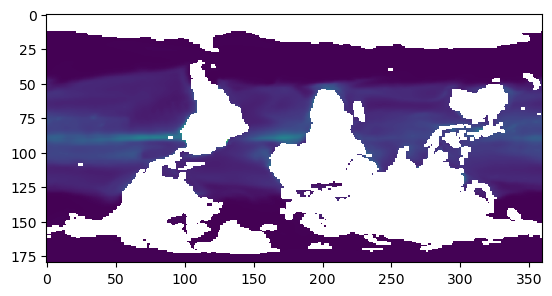

In [21]:
plt.imshow(np.nanmean(ppC.ppC_150m_zint,axis=(0,1)))

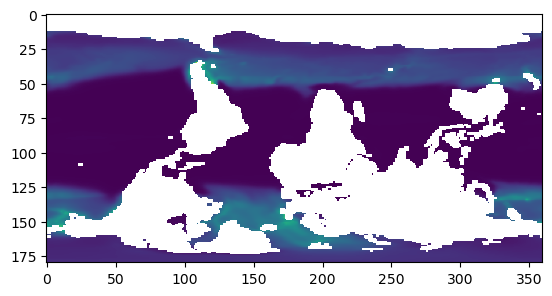

In [22]:
plt.imshow(np.nanmean(mp1C.mp1Chl,axis=(0,1)))

In [24]:
%%time
bmss = np.stack([ppC.ppC_150m_zint, mp1C.mp1Chl, diazC.diazChl, 
                   mp2C.mp2Chl, diat1C.diat1Chl, diat2C.diat2Chl, 
                   mp3C.mp3Chl, diat3C.diat3Chl, mp4C.mp4Chl])

CPU times: user 498 ms, sys: 1.14 s, total: 1.63 s
Wall time: 2.01 s


In [25]:
bmss_TOT = np.nansum(bmss,axis=0)
print(f' Total phytoplankton biomass summing phytoC in mmol m-3 {np.sum(bmss_TOT)}')

 Total phytoplankton biomass summing phytoC in mmol m-3 6474343.5
